# Introduction to Statistical Modeling: Linear Regression

**Overview**
- Concept of statistical modeling
- Defining statistical models with Patsy
- Linear regression
- Discrete regression: Logistic regression and Poisson model

We will use the [statsmodels](https://www.statsmodels.org/stable/index.html) libray which provides classes and functions for defining statistical models and fitting them to observed data, for calculating descriptive statistics and carrying out statistical tests. The api modules collect the publically accessible symbols that the library provides.

In [1]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

The [Patsy](https://patsy.readthedocs.io/en/latest/) library allows us to write statistical models as simple formulas. It is inspired by statiscal software such as R and S.   The statmodels library internally uses the Patsy library and thus we don't need to access the Patsy's functions directly. But we will use Patsy for demonstration.

In [2]:
import patsy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

**Main Problem:** For a set of response(dependent) variables $Y$, and explanatory(independent) variable $X$, we want to find a relationship (model) between $Y$ and $X$:
- mathematical model:         $~~~ Y = f(X)$
- statistical model:        $~~~ Y = f(X) + \epsilon~~$ where $\epsilon$ is a random variable. A model is statistical when the data ${y_i, x_i}$ has an element of uncertainty (e.g. due to measurement noise) which is described as $\epsilon$.


A widely used model is 
$$
Y = \beta_0 + \beta_1 X + \epsilon,
$$

where $\beta_0$ and $\beta_1$ are model parameters and $\epsilon$ is normally distributed with $0$ mean and variance $\sigma^2$. 
* If $X$ is a scalar, the model is known as *simple linear regression*.
* If $X$ is a vector, the model is known as *multiple linear regression*.
* If $Y$ is a vector, the model is known as *multivariate linear regression*.


After we form the model, we construct the so-called design matrices $y$ and $X$ such that the regression problem can be written in matrix form:

$$
  y = X\beta + \epsilon,
$$

where $y$ is the vector(or matrix) of observations, $\beta$ is a vector of coefficients and $\epsilon$ is the residual(error).

**Example:** 

Suppose the observed values are 
$$y = [1,2,3,4,5]$$
and there are two independent variables with values 
$$x_1 = [6,7,8,9,10]$$
and 
$$x_2 = [11,12,13,14,15]$$.  

Assume we use the linear model 
$$~ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2$$
(Note: *linear* with respect to the $\beta$ coefficents.) 

Therefore, the design matrix is 
$$X = [1, x_1, x_2, x_1x_2]$$.

Here is Python/NumPy to implement this

In [6]:
y = np.array([1,2,3,4,5])
x1 = np.array([6,7,8,9,10])
x2 = np.array([11,12,13,14,15])
X = np.vstack([np.ones(5),x1,x2,x1*x2]).T
X

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

Given $X$ and $y$, we can solve for $\beta$ using least-squares method:

In [7]:
beta, res, rank, svals = np.linalg.lstsq(X,y,rcond=None) #
np.linalg.lstsq?

In [8]:
print(beta)

[-5.55555556e-01  1.88888889e+00 -8.88888889e-01 -8.88900666e-16]


In the above example, constructing the design matrix $X$ was fairly simple. However, it can be more difficult for more complicated models. 

The `Patsy` library provides a simple [formula language](https://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language)  to handle this.

First, we create a dictionary that maps the variable names to the corresponding data arrays:

\[This is very similar to how in Sympy we associated symbol names with Python variables.\]

In [9]:
data = {"y":y, "x1":x1, "x2":x2}
print(data)

{'y': array([1, 2, 3, 4, 5]), 'x1': array([ 6,  7,  8,  9, 10]), 'x2': array([11, 12, 13, 14, 15])}


To use the model  
$$~ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2$$ 
with Patsy, we can use the formula `y ~ 1 + x1 + x2 + x1*x2` (leave out the coefficients).  

From the formulata we can easily get the design matrices:

In [10]:
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2")


In [11]:
# Look at y and compare with input
y

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [12]:
# Look at X and compare with manual construction
X

DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

We can also use the ordinary linear regression (OLS) class in the `statsmodels` library (instead of `np.linalg.lstsq`) to solve for the parameter vector:

In [13]:
model = sm.OLS(y, X) # construct the model
result = model.fit()

In [14]:
#compare this with the answer from np.linalg.lstsq
result.params

array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -1.11022302e-15])

We can skip the step of creating the design matrices by using the statmodels formula API (we imported it as `smf`) by the following:

In [15]:
model = smf.ols("y ~ 1 + x1 + x2 + x1*x2", data)
rsult = model.fit()
rsult.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.110223e-15
dtype: float64

In [18]:
df = pd.DataFrame(data)
model = smf.ols("y ~ x1*x2", df)
rsult = model.fit()
rsult.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.110223e-15
dtype: float64

This saves us time when we want to add and remove terms in the model. 

**Exercise:** Instead of using a Python dictionary, put `y`, `x1` and `x2` into a Pandas data frame, and solve using the `statsmodels` library.

In [ ]:
#look at C01 or the Pandas doc for how to make a data frame from a dictionary with data


### (Simplified) summary of the Patsy formula syntax

|Syntax|Example| Description |
|:-|:- |:---|
|lhs ~ rhs|y ~ x <br>(equivalent to y ~ 1+x) |~ is used to separate LHS (dependent variables) and <br> RHS (independent variables) | 
|var$*$var| x1$*$x2 <br>(equivalent to 1+x1+x2+x1$*$x2) |An interaction term that implicitly contains all lower-order terms|
|var + var| x1 + x2 <br>(equivalent to y ~ 1+x1+x2) |+ denotes the union of terms |
|var - var| x1 - x2 <br> |- removes the following term |
|var:var| x1:x2 |: denotes a pure interaction term (e.g. $x_1\cdot x_2$)|

For a complete syntax, see the Patsy [documentation](https://patsy.readthedocs.io/en/latest/).

In [ ]:
# Repeat above to show we can just specify x1*x2 (look at the 
# design matrices as well as at the solution)

In [ ]:
# x1 - x2 means I need x1 but exclude x2, not subtraction

# Linear Regression
**Basic workflow for analyzing a statistic model using statsmodels**:
1. Create an instance of model class, for example, using `mod = sm.MODEL(y,X)` or `mod = smf.model(formula, data)` where `MODEL` and `model` are the names of a particular model (e.g. OLS, GLS, Logit, etc)
2. Fit the model to the data:  `result = model.fit()`
3. Print summary statistics for the result:  `result.summary()`
4. Post-process the model fit results by methods and attributes `params`, `resid`, `fittedvalues`, `predict`
5. Visualize the result by Matplotlib or `statsmodels.graphics` module.


### Example (linear regression):
Consider fitting a model to generated data whose true value is $ y = 1 + 2x_1 + 3x_2 + 4x_1 x_2$.

* Sample 100 random data points in \[-2,2\] for our independent variables. 
* Put them into a data frame

In [19]:
N = 100
np.random.seed(128) # so we wll get the same values
x1 = 4*(np.random.random(N)-0.5)
x2 = 4*(np.random.random(N)-0.5)

Define a function to compute y_true and insert corresponding column of values into the data frame, then examine the frame

In [20]:
def y_true(x1,x2):
    return 1 + 2*x1 + 3*x2 + 4*x1*x2
    
y = y_true(x1,x2)
df = pd.DataFrame({"y":y, "x1":x1, "x2":x2})
df

,y,x1,x2
0,-3.713346,1.466548,-0.862427
1,-1.700133,-0.947421,1.019766
2,-5.471787,-1.474366,1.215910
3,1.887595,-1.833626,-1.050834
4,0.370654,-1.044303,-1.239591
...,...,...,...
95,-4.082885,1.407524,-0.915162
96,22.035355,1.926563,1.604878
97,12.028837,1.448662,0.924598
98,7.224447,1.479923,0.365999


Add normal-distributed noise to the true values and store the result in the "y" column of the data frame


In [22]:
noise = 0.1*np.random.randn(N)
df["y"] += noise


In [23]:
df.head()

,y,x1,x2
0,-3.756773,1.466548,-0.862427
1,-1.637434,-0.947421,1.019766
2,-5.394656,-1.474366,1.215910
3,1.890642,-1.833626,-1.050834
4,0.395560,-1.044303,-1.239591


**1st model: $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$ 

**Question:** what is the simplest corresponding Patsy model?  Replace the `????` below with the model.

In [25]:
# Step1: Create an instance of model class (fit the model to the data using ordinary least square)
model = smf.ols('y ~ x1+x2', df)


In [26]:
# Step2: Fit the model to the data
result = model.fit()

In [27]:
# Step3: Print summary statistics for the result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     38.27
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.61e-13
Time:                        11:11:54   Log-Likelihood:                -310.00
No. Observations:                 100   AIC:                             626.0
Df Residuals:                      97   BIC:                             633.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7810      0.557      1.403      0.1

*What to look for:*
- R-squared:  indicates how well the model fits the data. The value is between 0 and 1. The value 1 corresponds to a perfect fit.  
- The `coef` column contains the model parameters. 
- *t-statistics*:   $t$ = coef/(std err).  The greater $|t|$, the more likely that the corresponding coefficient is non-zero (which means that it has a significant predictive power). [Recall: the greater $|t|$, the greater the evidence against the null hypothesis. Here the null hypothesis is that the coefficient is $0$.]
- p-value:  small p-value (<0.05 ??) indicates that that coefficient is more likely to be non-zero.  [Recall: small p-value means strong evidence against the null hypothesis.]

Summary:  R-squared close to 1 => good fit. $~~~$High $t$ or small $p$-value => that coef is far from $0$. 

In [28]:
# We can also get the R-squared directly:
result.rsquared

0.44102095292522514

Note that by using ordinary least-square regression we assume that the residuals (of the fitted model and the data) is normally distributed.  Before analyzing data, we might not know if this condition is met. However, we can investigate this by using statistical tests (with null hypothesis that the residuals are normally distributed) and/or plotting the residual.

In [29]:
# we can look at the residual 
result.resid

0     -4.864006
1     -3.847219
2     -7.084110
3      9.063611
4      6.416794
        ...    
95    -4.897968
96    10.995518
97     4.672147
98     1.529951
99    -2.013437
Length: 100, dtype: float64

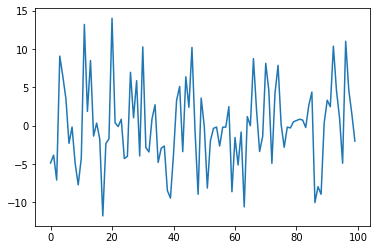

In [30]:
plt.plot(result.resid)

In [31]:
# Check the normality of the residual
z, p = stats.normaltest(result.resid.values)
print(p)

0.5263686046240125


Here $p$-value is large => accept null hypothesis (i.e. the assummption that the residuals are normally-distributed is not correct). (Recall that we're considering our first model ($Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$)


We can also use a graphical method (`qqplot`) to check for normality. The [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) compares the observed distribution of values between quantiles with that expected theoretically from the normal distribution. If the distribution is normal, you'll get the straight line $y = x$ (i.e., a line through the origin at 45 degrees assuming both axes are on the same scale).

Note: I don't really like these plots since how straight is straight enough or how close to 45 degrees?


In [ ]:
?smg.qqplot

D:\Software\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


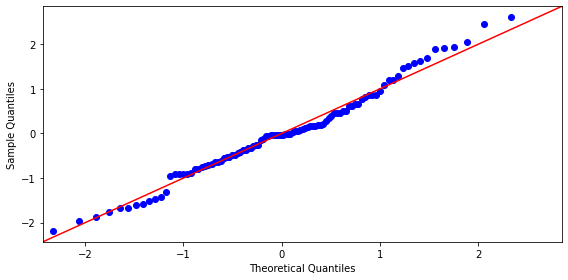

In [32]:
# Use the QQ graphical method to check for normality.
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax, fit=True, line="45") # need fit to get scales of x and y to match
fig.tight_layout()

This is (a little) more evidence that the first model is not sufficient.  

Let's add the interaction term:

**2nd model: $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 $   **.  

In [34]:
# Repeat the steps from the previous analysis (Steps 1-3)
model = smf.ols("y ~ x1*x2", df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.984e+04
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          2.34e-165
Time:                        11:25:59   Log-Likelihood:                 57.943
No. Observations:                 100   AIC:                            -107.9
Df Residuals:                      96   BIC:                            -97.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9937      0.014     70.331      0.000       0.966       1.022
x1             2.0132      0.012    164.497      0.000       1.989       2.037
x2             3.0084      0.012    247.915      0.000       2.984       3.032
x1:x2          3.9954      0.010    388.100      0.000       3.975       4.016
==============================================================================
Omnibus:                        6.435   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                9.826
Skew:                          -0.176   Prob(JB):                      0.00735
Kurtosis:                       4.495   Cond. No.                         1.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r-squared is very close to 1, indicating a nearly perfect fit.

Then we look at the residuals and check if the residuals are normally distributed:

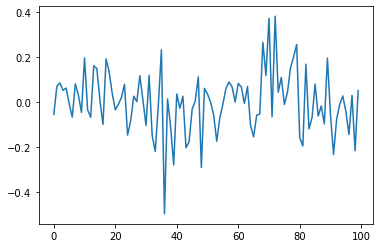

In [35]:
plt.plot(result.resid) # You'll see the residuals are much smaller

In [36]:
#1. statisical test
z, p = stats.normaltest(result.resid.values)
p # we want this to be small

0.04005062053063751

D:\Software\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


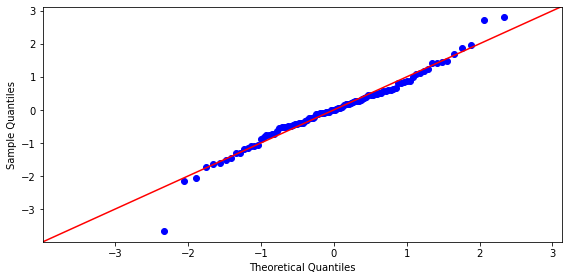

In [37]:
#2. qq-plot 
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax, fit=True, line="45")

fig.tight_layout()

Repeat with 10000 points to see how the two QQ plots differ with more data.

If we are happy with the fitted model, we can extract the model parameters:

In [38]:
result.params

Intercept    0.993673
x1           2.013167
x2           3.008375
x1:x2        3.995357
dtype: float64

Given values of the indepedent variables ($x_1$, and $x_2$ in this case), we can use the `predict` method to get the prediction (the $y$ value).

Compute the predictions on a 50x50 mesh between -2 and 2.

In [39]:
x = np.linspace(-2,2,50)
X1, X2 = np.meshgrid(x,x)
X1 = X1.ravel()
X2 = X2.ravel()
print(X1)
print(X2)


[-2.         -1.91836735 -1.83673469 ...  1.83673469  1.91836735
  2.        ]
[-2. -2. -2. ...  2.  2.  2.]


In [40]:
newdata = pd.DataFrame({"x1":X1, "x2":X2})
ynew = result.predict(newdata)
ynew.describe()

count    2500.000000
mean        0.993673
std         6.996134
min       -16.978171
25%        -2.910216
50%        -0.186493
75%         3.920296
max        27.018185
dtype: float64

In [41]:
ynew = np.array(ynew)

In [42]:
# the result is a vector
ynew.shape

(2500,)

In [43]:
# so we must reshape it into a 50x50 grid/mesh/matrix
ynew = ynew.reshape(50,50)
ynew.shape

(50, 50)

In [44]:
# also reshape the X1 and X2 vectors to a square matrix
X1 = X1.reshape(50,50)
X2 = X2.reshape(50,50)

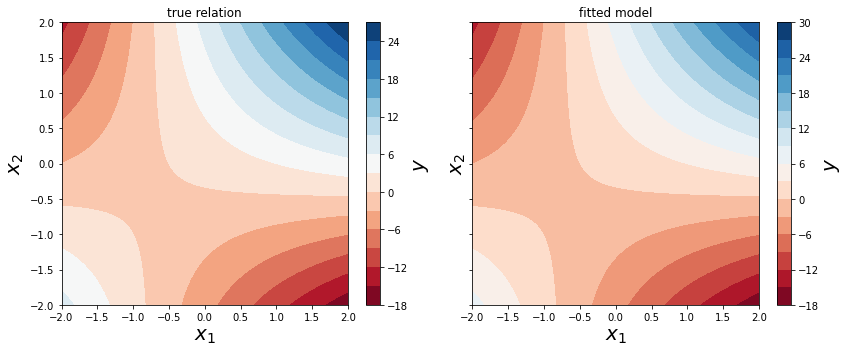

In [45]:
# plot the true data and the fitted model
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], ynew, "fitted model")

fig.tight_layout()

### Datasets from R
The statmodels provides an interface to load data sets to explore.  See http://www.statsmodels.org/dev/datasets/index.html#available-datasets  for available data sets.

As an example, we will load a dataset named "Icecream" from the package "Ecdat":

In [46]:
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat")

In [47]:
dataset.data

,cons,income,price,temp
0,0.386,78,0.270,41
1,0.374,79,0.282,56
2,0.393,81,0.277,63
3,0.425,80,0.280,68
4,0.406,76,0.272,69
5,0.344,78,0.262,65
6,0.327,82,0.275,61
7,0.288,79,0.267,47
8,0.269,76,0.265,32
9,0.256,79,0.277,24


In [48]:
dataset.data.temp

0     41
1     56
2     63
3     68
4     69
5     65
6     61
7     47
8     32
9     24
10    28
11    26
12    32
13    40
14    55
15    63
16    72
17    72
18    67
19    60
20    44
21    40
22    32
23    27
24    28
25    33
26    41
27    52
28    64
29    71
Name: temp, dtype: int64

We see that this dataset has 4 variables: cons(consumption), income, price, and temp. 

**Exercise:** Model the consumption as a linear model with price and temperature as indepdent variables without an intercept/constant term (i.e., forcing the intercept to be zero):

In [57]:
model = smf.ols("cons ~ income+temp+price -1", dataset.data) # -1 remove intercept
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   cons   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              991.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):                    1.02e-27
Time:                        11:41:13   Log-Likelihood:                          58.315
No. Observations:                  30   AIC:                                     -110.6
Df Residuals:                      27   BIC:                                     -106.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
income         0.0038      0.001      3.795      0.001       0.002       0.006
temp           0.0036      0.000      8.573      0.000       0.003       0.004
price         -0.4851      0.328     -1.479      0.151      -1.158       0.188
==============================================================================
Omnibus:                        1.121   Durbin-Watson:                   1.034
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.356
Skew:                           0.219   Prob(JB):                        0.837
Kurtosis:                       3.304   Cond. No.                     4.83e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

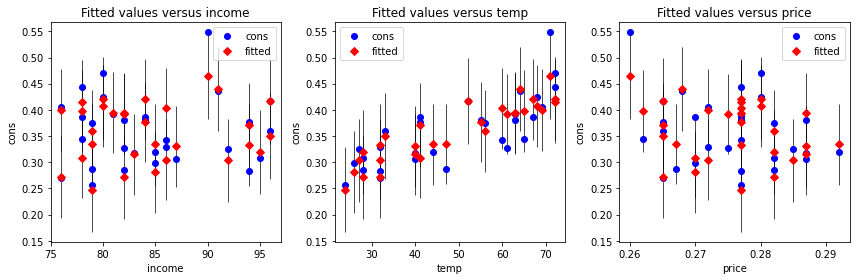

In [62]:
# Graphical tools like plot_fit (regression plot) can give a quick look at our fitted model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

smg.plot_fit(result, 0, ax=ax1)
smg.plot_fit(result, 1, ax=ax2)
smg.plot_fit(result, 2, ax=ax3)

fig.tight_layout()

The consumption seems linearly correlated to the temp but doesn't seem so on the price (it's perhaps because the price range is quite small). 

## References: 
- *Numerical Python: A Practical Techniques Approach for Industry*  by Robert Johansson (Chapter 14)